In [15]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [16]:
# fix random seed for reproducibility
np.random.seed(0)

In [17]:
# load data and drop the date column
dataset = pd.read_csv("airline-passengers.csv", usecols=[1], engine='python')

# convert integers to floats
dataset = dataset.astype('float32')

In [18]:
# normalize the dataset to range (0,1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [19]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [20]:
# create input-output pairs for LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [21]:
# reshape input to be [samples, time steps, features]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [22]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back), activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
93/93 - 1s - loss: 0.1081 - 711ms/epoch - 8ms/step
Epoch 2/100
93/93 - 0s - loss: 0.0379 - 121ms/epoch - 1ms/step
Epoch 3/100
93/93 - 0s - loss: 0.0210 - 114ms/epoch - 1ms/step
Epoch 4/100
93/93 - 0s - loss: 0.0177 - 117ms/epoch - 1ms/step
Epoch 5/100
93/93 - 0s - loss: 0.0166 - 103ms/epoch - 1ms/step
Epoch 6/100
93/93 - 0s - loss: 0.0159 - 112ms/epoch - 1ms/step
Epoch 7/100
93/93 - 0s - loss: 0.0155 - 105ms/epoch - 1ms/step
Epoch 8/100
93/93 - 0s - loss: 0.0148 - 110ms/epoch - 1ms/step
Epoch 9/100
93/93 - 0s - loss: 0.0142 - 107ms/epoch - 1ms/step
Epoch 10/100
93/93 - 0s - loss: 0.0138 - 115ms/epoch - 1ms/step
Epoch 11/100
93/93 - 0s - loss: 0.0132 - 113ms/epoch - 1ms/step
Epoch 12/100
93/93 - 0s - loss: 0.0126 - 109ms/epoch - 1ms/step
Epoch 13/100
93/93 - 0s - loss: 0.0122 - 113ms/epoch - 1ms/step
Epoch 14/100
93/93 - 0s - loss: 0.0117 - 116ms/epoch - 1ms/step
Epoch 15/100
93/93 - 0s - loss: 0.0111 - 112ms/epoch - 1ms/step
Epoch 16/100
93/93 - 0s - loss: 0.0107 - 109ms/ep

In [23]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

2/2 [==============================] - 0s 2ms/step


In [24]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [25]:
# calculate root mean squared error
trainScore = np.sqrt(np.mean(np.square(trainY - trainPredict)))
testScore = np.sqrt(np.mean(np.square(testY - testPredict)))
print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Test Score: {testScore:.2f} RMSE')

Train Score: 95.16 RMSE
Test Score: 94.37 RMSE


In [26]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [27]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict

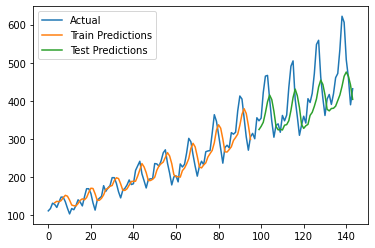

In [28]:
# plot baseline and predictions
actual = scaler.inverse_transform(dataset)
plt.plot(actual, label='Actual')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.legend()
plt.show()